In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn import cluster
from sklearn.metrics import silhouette_samples, silhouette_score
import plotly.express as px
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
np.random.seed(0)

%matplotlib inline
sns.set()

# Unsupervised Learning: Visualizing World Bank Development Data using multi-dimensional clustering and PCA

#### Rhea Manoharan

This data is from https://databank.worldbank.org/source/world-development-indicators# and contains various features on development indicators for the world's countries. 

#### I am primarily interested in the following questions: 
(1) Can countries be grouped into distinct clusters based on development indicators? Will unsupervised learning on this dataset create clusters correlating mostly to economic factors, or are there other defining variables? 

(2) Can we visualize a cluster of countries in 2 dimensions to analyze the intra-cluster similaritiees? 


In [75]:
#normalizing data
world_bank_data = pd.read_csv("world_bank_data.csv", index_col = 'country')
world_bank_data = world_bank_data.fillna(0)
world_bank_data.head(5)

std_scaler = StandardScaler()
wb_scaled = std_scaler.fit_transform(world_bank_data.to_numpy())
wb_scaled  = pd.DataFrame(wb_scaled, columns = world_bank_data.columns)
wb_scaled["country"] = list(world_bank_data.index)
wb_scaled = wb_scaled.set_index("country")

For n_clusters = 3 The average silhouette_score is : 0.24636842095303674
For n_clusters = 4 The average silhouette_score is : 0.2519364830313927
For n_clusters = 5 The average silhouette_score is : 0.20305153838885498


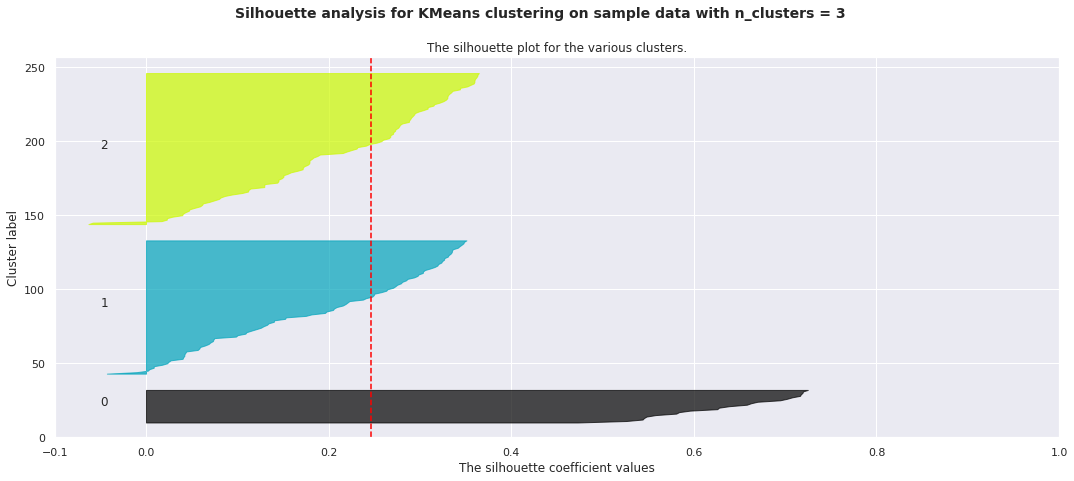

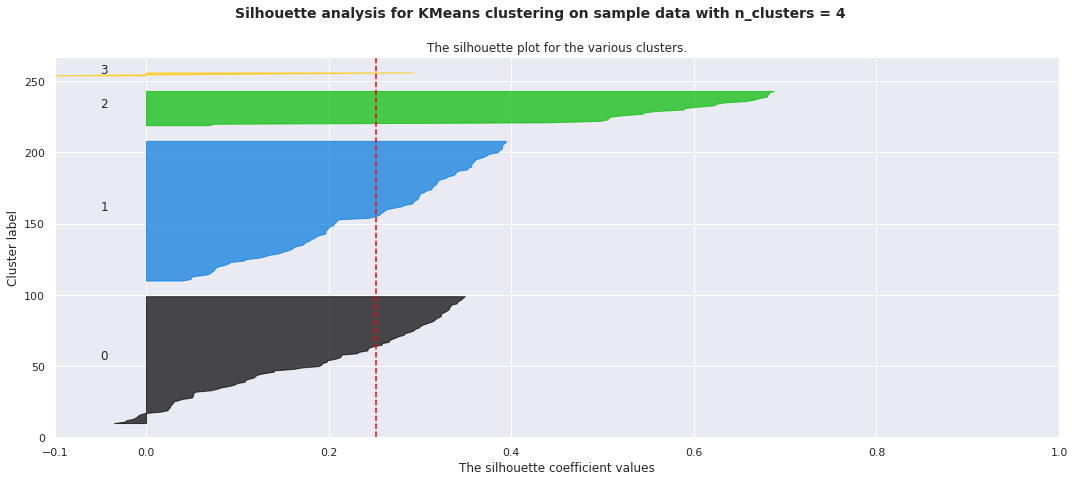

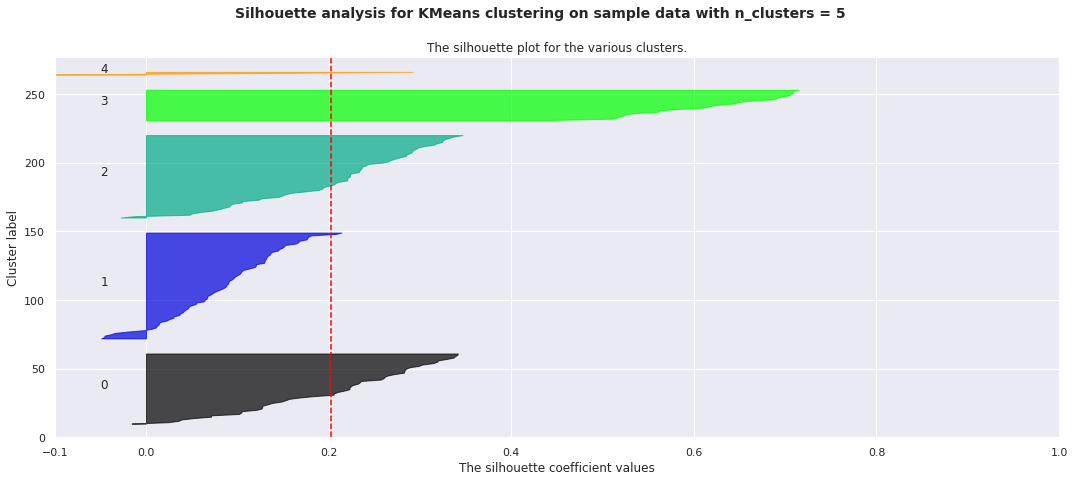

In [68]:
#creating silhouette plots to see how many clusters is optimal
# code taken and adapted from sk.learn cluster documentation 
X = wb_scaled

range_n_clusters = [3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    #ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Creating the K-Means Algorithm 

It appears that 4 clusters is optimal in this case: Therefore we will be creating a k-means algorithm on the normalized world bank data. 

In [78]:
#Creating a K-means model which creates 4 clusters of countries.
kmeans_q4 = cluster.KMeans(n_clusters = 4, random_state = 42).fit(world_bank_data)

## Analyzing the Clusters

Upon initial viewing of the clusters, it appears that clusters are mainly seperated by population size and global economic contribution. 

In [77]:
labeled_world_bank_data = world_bank_data.copy()
labeled_world_bank_data['cluster'] = kmeans_q4.labels_
data = [["Cluster 1", list(labeled_world_bank_data.query('cluster == 0').index)],
        ["Cluster 2", list(labeled_world_bank_data.query('cluster == 1').index)],
        ["Cluster 3", list(labeled_world_bank_data.query('cluster == 2').index)], 
        ["Cluster 4", list(labeled_world_bank_data.query('cluster == 3').index)]]
newdf = pd.DataFrame(data, columns= ["Cluster", "Countries"])
newdf

,Cluster,Countries
0,Cluster 1,"[Algeria, Afghanistan, Albania, American Samoa..."
1,Cluster 2,"[China, United States]"
2,Cluster 3,"[Germany, India, Japan]"
3,Cluster 4,"[Australia, Brazil, Canada, France, Indonesia,..."


## PCA visualizing one cluster 

To more clearly see the similarities within a cluster- we can find which features explain the most variance in a cluster- in other words, by finding the top feature contributions to the first two principal components, we can begin to understand which features might be important to a model/diffrentiating countries within one cluster. 

In [71]:
#Creating a dataframe of only cluster 4
wb_scaled2 = wb_scaled.copy()
wb_scaled2['cluster'] = kmeans_q4.labels_
wb_scaled2["country"] = list(world_bank_data.index)
wb_scaled2 = wb_scaled2.loc[wb_scaled2["cluster"] == 3]

#Finding the first two principal components of the scaled data by hardcoding PCA
u_q3, s_q3, vt_q3 = np.linalg.svd(wb_scaled2.drop("country", axis=1), full_matrices =False)
first_2_pcs = pd.DataFrame((u_q3*s_q3)[:, 0:2], columns = ["pc1", "pc2"])

def plot_pc(col_names, vt, k):
    plt.bar(col_names, vt[k, :], alpha=0.7)
    plt.xticks(col_names, rotation=90);

first_2_pcs_jittered["country"] = list(wb_scaled2.index)
fig = px.scatter(first_2_pcs_jittered, x = "pc1", y= "pc2", text ="country")
fig.update_traces(textposition = "top center")
fig.show();

In [73]:
wb_scaled2 = wb_scaled2.drop("country", axis = 1)
pcamodel = PCA(n_components=2).fit(wb_scaled2)
X_pc = pcamodel.transform(wb_scaled2)

# number of components
n_pcs= pcamodel.components_.shape[0]

# get the index of the most important feature on EACH component
top_components = [np.abs(pcamodel.components_[i]).argmax() for i in range(n_pcs)]
feature_names = list(wb_scaled2.columns)
most_important_names = [feature_names[top_components[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build a dataframe with the 
df = pd.DataFrame(dic.items(), columns= ["PCA component", "Top Feature contribution"])
df

,PCA component,Top Feature contribution
0,PC0,"Mammal species, threatened"
1,PC1,Surface area (sq. km)


 It appears that environmental/geographic factors contribute most to the first two principal components in the fourth cluster. Similar analyses, with a combination of PCA and domain knowledge, can be done to find the most influential factors in each cluster. This indicates that optimal clustering of this World Bank data is much more complex than my original hypothessis of clustering based mainly on economic factors.